In [1]:
import pandas as pd
from tqdm import tqdm
import os
import datetime
import librosa as lb
# Load the TensorBoard notebook extension
%load_ext tensorboard
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, MaxPooling1D,GlobalAveragePooling2D,  BatchNormalization

Using TensorFlow backend.


In [2]:
file_data = pd.read_csv('file_data.csv')

In [3]:
file_data

,fname,start,end,crack_wheez,fname_cycle,len
0,101_1b1_Al_sc_Meditron,0.036,0.579,0,101_1b1_Al_sc_Meditron_0.wav,0.543
1,101_1b1_Al_sc_Meditron,0.579,2.450,0,101_1b1_Al_sc_Meditron_1.wav,1.871
2,101_1b1_Al_sc_Meditron,2.450,3.893,0,101_1b1_Al_sc_Meditron_2.wav,1.443
3,101_1b1_Al_sc_Meditron,3.893,5.793,0,101_1b1_Al_sc_Meditron_3.wav,1.900
4,101_1b1_Al_sc_Meditron,5.793,7.521,0,101_1b1_Al_sc_Meditron_4.wav,1.728
...,...,...,...,...,...,...
6852,226_1b1_Pl_sc_LittC2SE,11.721,13.693,1,226_1b1_Pl_sc_LittC2SE_6.wav,1.972
6853,226_1b1_Pl_sc_LittC2SE,13.693,15.536,0,226_1b1_Pl_sc_LittC2SE_7.wav,1.843
6854,226_1b1_Pl_sc_LittC2SE,15.536,17.493,0,226_1b1_Pl_sc_LittC2SE_8.wav,1.957
6855,226_1b1_Pl_sc_LittC2SE,17.493,19.436,1,226_1b1_Pl_sc_LittC2SE_9.wav,1.943


In [4]:
# Split data into train and test sets
train_df, test_df = train_test_split(file_data, test_size=0.2, random_state=0)

In [5]:
#Set maxpad length as 79 <--(Sampling rate*5s)/256(hop length)
def build_feat(df):
    X = []
    Y = []
    max_pad_len = 79
    for i in tqdm(range(len(df))):
        file = df.iloc[i].fname_cycle
        label = df.iloc[i].crack_wheez
        wav,  rate = lb.load('Breath_cycles/'+ file, sr=None)
        #limit the length of samples to only 6s (6*4000)
        if wav.shape[0] > 20000:
            wav = wav[0:20000]
        X_sample = lb.feature.mfcc(wav, sr=rate, n_fft=512,  win_length=400, n_mfcc=20, hop_length = 256, n_mels = 128, fmin = 100, fmax = 1800)
        pad_width = max_pad_len - X_sample.shape[1]
        X_sample = np.pad(X_sample, pad_width=((0, 0), (0, pad_width)), mode='constant')
        X.append(X_sample)
        Y.append(label)
    X, Y = np.array(X), np.array(Y)
    return X, Y

In [6]:
#Extract features for training data
X_, y_ = build_feat(train_df)

100%|██████████| 5485/5485 [01:01<00:00, 89.84it/s]


In [7]:
#Extract feature for testing data
X_val, y_val = build_feat(test_df)

100%|██████████| 1372/1372 [00:15<00:00, 89.51it/s]


In [8]:
X_tr = X_.reshape((-1,X_.shape[1], X_.shape[2], 1))
X_val = X_val.reshape((-1,X_val.shape[1], X_val.shape[2], 1))

In [9]:
#Convert labels into one hot vectors
y_tr_cat= to_categorical(y_, num_classes=4)
y_val_cat= to_categorical(y_val, num_classes=4)

In [10]:
csv_path = os.path.join('logs', 'log_history_cnn.csv')
#Save model checkpoints
cp = ModelCheckpoint('models/cnn_5s.h5', monitor='val_accuracy',  save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
csv_logger = CSVLogger(csv_path, append=False)

In [11]:
model = tf.keras.models.Sequential()

model.add(Conv2D(filters=32, kernel_size=3,  input_shape=(X_tr.shape[1], X_tr.shape[2], 1)))

model.add(Conv2D(filters=64, kernel_size=3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))


model.add(Conv2D(filters=128, kernel_size=3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(32,activation='relu', activity_regularizer=regularizers.l2(0.001)))

model.add(Dense(4,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 77, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 75, 64)        18496     
_________________________________________________________________
activation (Activation)      (None, 16, 75, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 37, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 37, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 35, 128)        73856     
_________________________________________________________________
activation_1 (Activation)    (None, 6, 35, 128)        0

In [12]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [13]:
#Fit model
model.fit(X_tr,y_tr_cat, epochs = 100, workers=4, batch_size = 64, validation_data=(X_val, y_val_cat), callbacks=[csv_logger, cp], verbose = True)

Epoch 1/100
86/86 [==============================] - ETA: 0s - loss: 1.6068 - accuracy: 0.4935
Epoch 00001: val_accuracy improved from -inf to 0.53644, saving model to models/cnn_5s.h5
86/86 [==============================] - 25s 290ms/step - loss: 1.6068 - accuracy: 0.4935 - val_loss: 1.1457 - val_accuracy: 0.5364
Epoch 2/100
86/86 [==============================] - ETA: 0s - loss: 1.1166 - accuracy: 0.5242
Epoch 00002: val_accuracy improved from 0.53644 to 0.54373, saving model to models/cnn_5s.h5
86/86 [==============================] - 24s 281ms/step - loss: 1.1166 - accuracy: 0.5242 - val_loss: 1.1520 - val_accuracy: 0.5437
Epoch 3/100
86/86 [==============================] - ETA: 0s - loss: 1.0923 - accuracy: 0.5338
Epoch 00003: val_accuracy improved from 0.54373 to 0.56778, saving model to models/cnn_5s.h5
86/86 [==============================] - 25s 289ms/step - loss: 1.0923 - accuracy: 0.5338 - val_loss: 1.0804 - val_accuracy: 0.5678
Epoch 4/100
86/86 [========================

In [14]:
# It can be used to reconstruct the model identically.
saved_model = keras.models.load_model("models/cnn_5s.h5")

                precision    recall  f1-score   support

          None       0.72      0.80      0.76       737
       Crackle       0.58      0.64      0.61       358
        Wheeze       0.74      0.34      0.47       189
Crackle_wheeze       0.50      0.41      0.45        88

      accuracy                           0.67      1372
     macro avg       0.63      0.55      0.57      1372
  weighted avg       0.67      0.67      0.66      1372



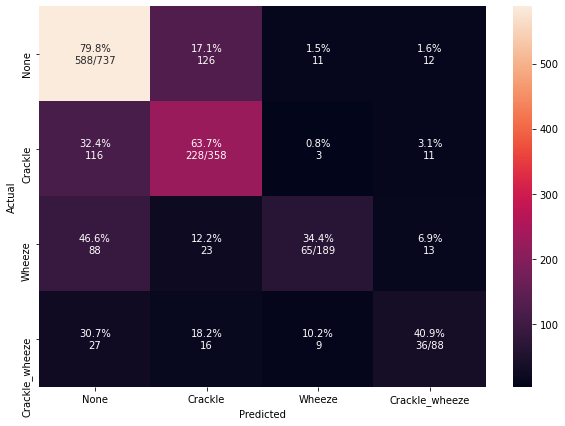

In [15]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
matrix_index = ["None", "Crackle", "Wheeze", "Crackle_wheeze"]

preds = saved_model.predict(X_val)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_val_cat, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='')